# How does Othello-GPT edit its world model?

In [1]:
# imports
import transformer_lens as lens
from transformer_lens import HookedTransformer, HookedTransformerConfig
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import einops
from fancy_einsum import einsum

/home/aidan/Documents/Programming/autocircuit/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# get model from hf
model = HookedTransformer.from_pretrained("othello-gpt")

Loaded pretrained model othello-gpt into HookedTransformer


In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
# get Neel Nanda's linear probes and convert them to the HookedTransformer format
# going to focus on layer 6 because apparently that one works pretty good
probe = torch.load("main_linear_probe.pth", map_location=device)

In [5]:
# indexing
itos = [-100] + list(range(0,27)) + list(range(30,35)) + list(range(37,64))
stoi = {s:i for i,s in enumerate(itos)}


rows = list("abcdefgh")
columns = [str(_) for _ in range(1, 9)]

def permit(s):
    s = s.lower()
    if len(s) != 2:
        return -1
    if s[0] not in rows or s[1] not in columns:
        return -1
    return rows.index(s[0]) * 8 + columns.index(s[1])

import textwrap

In [6]:
dataset_moves = textwrap.wrap("C4c3E6", 2)
dataset_tokens = torch.tensor([stoi[permit(move)] for move in dataset_moves]).unsqueeze(0).to(device)

cf_moves = textwrap.wrap("C4c3D3", 2)
cf_tokens = torch.tensor([stoi[permit(move)] for move in cf_moves]).unsqueeze(0).to(device)

In [7]:
import autocircuit.transformer_lens as ac_lens
import autocircuit as ac

graph, hook_manager = ac_lens.build_graph(model, n_ctx=3)

gm = ac.GraphedModel(model, graph, hook_manager)

In [8]:
_, dataset_cache = gm.run_with_cache(dataset_tokens)
_, cf_cache = gm.run_with_cache(cf_tokens)

In [9]:
out = ac.autocircuit(gm, "2.7.resid_mid", dataset_tokens, cf_cache, 0.5)

ablated 2.7.mlp_out
ablated 2.7.resid_mid
2.7.resid_post has important children ['2.7.resid_mid'] and mean diff 2.0462452089414
ablated 2.6.resid_post
ablated 2.7.reader.0
ablated 2.7.reader.1
ablated 2.7.reader.2
ablated 2.7.reader.3
ablated 2.7.reader.4
ablated 2.7.reader.5
ablated 2.7.reader.6
ablated 2.7.reader.7
2.7.resid_mid has important children ['2.6.resid_post'] and mean diff 0.4548670103152593
ablated 2.6.mlp_out
ablated 2.6.resid_mid
2.6.resid_post has important children ['2.6.mlp_out', '2.6.resid_mid'] and mean diff 3.0927207469940186
ablated 2.6.resid_mid
2.6.mlp_out has important children ['2.6.resid_mid'] and mean diff 4.0697784423828125
ablated 2.5.resid_post
ablated 2.6.reader.0
ablated 2.6.reader.1
ablated 2.6.reader.2
ablated 2.6.reader.3
ablated 2.6.reader.4
ablated 2.6.reader.5
ablated 2.6.reader.6
ablated 2.6.reader.7
2.6.resid_mid has important children ['2.5.resid_post'] and mean diff 0.4522786635983114
ablated 2.5.mlp_out
ablated 2.5.resid_mid
2.5.resid_post h

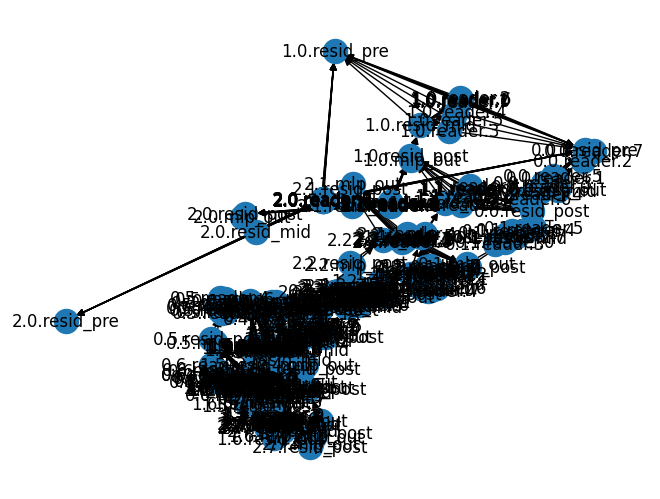

In [10]:
import autocircuit.visualise as vis

vis.draw_graph(graph)